In [1]:
class WarGraphNode():
    def __init__(self, name, n_edges=3, initial_energy=0):
        self.name = name
        self.edges = []
        self.initial_energy = initial_energy
        self.energy = self.initial_energy
        self.occupied = self.energy > 0
        self.n_edges = n_edges
        self.full = False

    def _reset_all(self):
        self.energy = self.initial_energy
        self.occupied = self.energy > 0
        self.edges = []
        self.full = False

    def reset(self):
        self.energy = self.initial_energy
        self.occupied = self.energy > 0

    def __str__(self):
        return self.name

    def __repr__(self):
        return f"WarGraphNode(name={self.name}, energy={self.energy}, occupied={self.occupied}, edges={self.edges}, n_edges={self.n_edges}, full={self.full})"

In [15]:
import random
# WarGraph class
class WarGraph():
    def __init__(self, nodeName, n_edges=3, random_mainNode=True):
        self.random_mainNode = random_mainNode
        headEnergy = 100 if not self.random_mainNode else 0
        self.n_edges = n_edges
        self.headNode = WarGraphNode(name=nodeName, n_edges=self.n_edges,
                                       initial_energy=headEnergy)  # self.mainNode -> self.headNode as this node may not be mainNode
        self.adj_list = {self.headNode.name: []}
        self.nodes = {self.headNode.name: self.headNode}
        self.available_nodes = {self.headNode.name: self.headNode}

        self.initialized = False

    # add node
    def addNode(self, target, nodeName: str):
        assert target in self.adj_list, "Target node not exist"
        targetNode = self.nodes[target]

        node = self.nodes[nodeName] if nodeName in self.adj_list.keys() else self.nodeClass(nodeName)

        # update edges for target node and new node
        targetNode.edges.append(node.name)
        node.edges.append(targetNode.name)

        # update adjacency list
        self.adj_list[node.name] = node.edges
        self.adj_list[targetNode.name] = targetNode.edges

        # update nodes
        if node.name not in self.nodes.keys():
            self.nodes[node.name] = node

    # after reset_nodes(), mainNode need to be reintialized again
    def reset_nodes(self):
        for node in self.nodes.values():
            node.reset()
        self.initialized = False

    def initialize_mainNode(self, nodeName=None):
        if self.initialized:
            return
            # param nodeName has higher priority than self.random_mainNode
        if not nodeName:
            assert self.random_mainNode, "Please specify nodeName for mainNode or set self.random_mainNode as True"
            nodeName = random.choice(list(self.nodes.keys()))
        else:
            assert nodeName in self.nodes.keys(), "Specified nodeName not exist"
        mainNode = self.nodes[nodeName]
        mainNode.energy = 100
        mainNode.occupied = True
        self.initialized = True
        return mainNode

    def generate_graph(self, n_nodes, n_edges=5, index_constraint=None):
      available_nodes = {self.headNode.name: self.headNode}
      for n in range(1, n_nodes):
        # create a newNode
        newNode = WarGraphNode(n, n_edges=n_edges)

        # randomly select a node where its capacity is not full(not node.full)
        index_constraint = index_constraint if index_constraint else - int(n_nodes / 2)
        selected_nodeName = random.choice(list(available_nodes.keys())[index_constraint:])   # only select from last 10 available nodes
        selectedNode = available_nodes[selected_nodeName]

        # update their edges
        newNode.edges.append(selected_nodeName)
        selectedNode.edges.append(n)

        # add new node to graph.nodes
        self.nodes[n] = newNode

        # update available nodes
        available_nodes[n] = newNode

        # update adjacency list
        self.adj_list[newNode.name] = newNode.edges
        self.adj_list[selectedNode.name] = selectedNode.edges


        # if node.full, remove its key from available nodes
        newNode.full = len(newNode.edges) == newNode.n_edges
        if newNode.full:
          _ = available_nodes.pop(n)
        selectedNode.full = len(selectedNode.edges) == selectedNode.n_edges
        if selectedNode.full:
          _ = available_nodes.pop(selectedNode.name)

      return self.nodes

    def diffusion(self, selected_nodeName: str, target_nodeName: str):
        assert self.initialized, "Please call self.initialize_mainNode() before diffusion operation"
        assert not selected_nodeName == target_nodeName, "Selecting same selected node and target node is invalid"
        assert selected_nodeName in self.adj_list, "Selected node not exist"
        assert target_nodeName in self.adj_list, "Target node not exist"
        assert target_nodeName in self.nodes[selected_nodeName].edges, "Target node is not an edge of selected node"
        diffusable_nodes = [k for k, v in self.nodes.items() if v.energy > 50]
        # print("Diffusable nodes:", diffusable_nodes)

        selected_node = self.nodes[selected_nodeName]
        assert selected_node.energy > 50, "Not enough energy"

        # print("All good")
        # print("Selected node edges:", selected_node.edges)

        # select one of the edge and diffuse selected node's energy
        target_node = self.nodes[target_nodeName]
        assert not target_node.occupied, "Target node has been occupied"

        target_node.energy = 50
        target_node.occupied = True
        selected_node.energy -= 50

    def __repr__(self):
        return f"WarGraph(headNode={self.headNode})"


In [ ]:
graph = WarGraph('S', n_edges=5)
nodes = graph.generate_graph(n_nodes=30, n_edges=3)
nodes

In [ ]:
graph.nodes

In [4]:
import gym
import numpy as np
from gym.spaces import MultiDiscrete
import matplotlib.pyplot as plt

In [21]:
### main.py

class NodeInvasionEnv(gym.Env):
    def __init__(self, max_timestep=200, render_mode='np_array', graph=None, mainNode='S', n_nodes=30, n_edges=5, delta_energy=1):
        self.max_timestep = max_timestep if render_mode == 'np_array' else 120    # 'human' render mode takes 30x longer time to run an episode
        self.delta_energy = delta_energy
        self.timestep = 0
        self.graph = graph
        self.mainNode = mainNode
        if not self.graph:
            self.graph = WarGraph(mainNode, n_edges=7)
            nodes = self.graph.generate_graph(n_nodes=n_nodes, n_edges=n_edges)
            self.graphNodes = self.graph.nodes
        self.graph.reset_nodes()
        self.graph.initialize_mainNode(mainNode)   # mainNode can be changed later
        self.graphNodes = self.graph.nodes
        self.graphNodeIdx = {idx: i for idx, i in enumerate(list(self.graph.nodes.keys()))}   # index for each nodes
        self.inv_graphNodeIdx = {v:k for k, v in self.graphNodeIdx.items()}
        self.obs = np.array([(node.energy, int(node.occupied)) for node in self.graphNodes.values()])
        self.n_nodes = self.obs.shape[0]
        self.observation_space = MultiDiscrete([101, 2])
        self.action_space = MultiDiscrete([self.n_nodes] * 2)

    def reset(self):
        self.timestep = 0
        self.graph.reset_nodes()
        self.graph.initialize_mainNode(self.mainNode)
        return np.array([(node.energy, int(node.occupied)) for node in self.graph.nodes.values()])

    # update energy per second
    def __update_energy(self):
        for gNode in self.graphNodes.values():
            if gNode.occupied and gNode.energy < 100:
                gNode.energy += self.delta_energy

    def step(self, action):
        # 1. diffuse energy
        selected_nodeName, target_nodeName = self.graphNodeIdx[action[0]], self.graphNodeIdx[action[1]]
        # print(selected_nodeName, target_nodeName)
        try:
            self.graph.diffusion(selected_nodeName, target_nodeName)
            # print(gameGraph.nodes)
            # reward = 0
            reward = int(sum(self.obs[:, 0]) / self.n_nodes)
        except AssertionError as ae:
            reward = -1

        # 2. update energy
        self.__update_energy()

        # update obs
        self.obs = np.array([(node.energy, int(node.occupied)) for node in self.graphNodes.values()])

        # update timestep
        self.timestep += 1

        # truncation
        truncation = self.timestep >= self.max_timestep

        # termination
        termination = sum(self.obs[:, 0]) / self.n_nodes == 100

        done = truncation or termination

        # update reward if done
        if done:
            reward = int(sum(self.obs[:, 0]) / self.n_nodes)

        return self.obs, reward, done, dict()

    @staticmethod
    def visualize_rewards(rewards):
        plt.plot(rewards)
        plt.xlabel("Timestep")
        plt.ylabel("Reward")
        plt.show()

    def render(self, mode="human"):
        raise NotImplementedError

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = NodeInvasionEnv(n_nodes=30, n_edges=3)
env.graph.nodes

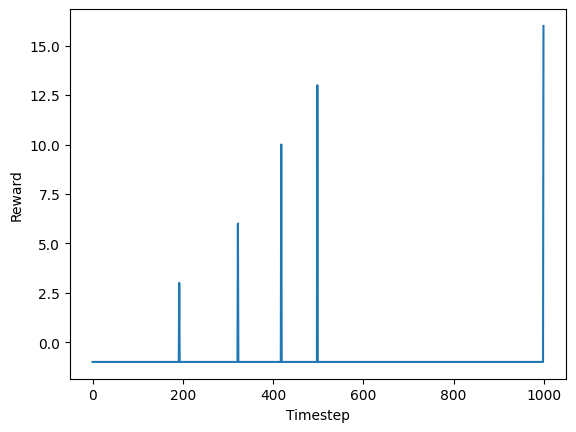

In [9]:
# test env
env = NodeInvasionEnv(max_timestep=1000)

rewards = []
obs_records = []

obs = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    next_obs, reward, done, _ = env.step(action)
    obs = next_obs

    # record rewards and obs
    rewards.append(reward)
    obs_records.append(obs)

env.visualize_rewards(rewards)

In [ ]:
# bug: selected node can diffuse to target node where not selected node's edges
_ = env.reset()
env.graph.nodes

In [23]:
env.graph.diffusion('S', 3)

AssertionError: ignored

In [24]:
# add render function
import networkx as nx
import math
import os


def render(G, node_color):
  labels = nx.get_node_attributes(G, 'energy')

  plt.figure(figsize=(17, 17))
  subax1 = plt.subplot(224)

  # set seed to fix position of all nodes
  # nx.draw(G, node_color=node_color, pos=nx.spring_layout(G, seed=1), labels=labels, font_weight='bold')

  optimal_distance = (1 / math.sqrt(G.number_of_nodes())) * 2   # double of default optimal distance
  nx.draw_networkx(G, node_color=node_color, pos=nx.spring_layout(G, seed=1, k=optimal_distance),
                  labels=labels, font_size=10, font_weight='bold', node_size=350)

In [25]:
# initialize nx graph
def initialize_nx_graph(nodes: dict[str, WarGraphNode]):
  G = nx.Graph()
  node_color_dict = dict()
  for node in nodes.values():
    color = 'lightgray' if node.energy == 0 else 'lightskyblue'
    node_color_dict[node.name] = color
    G.add_node(node.name, energy=node.energy, full=node.full)
  node_color = list(node_color_dict.values())

  for node in nodes.values():
    u = node.name
    for v in node.edges:
      G.add_edge(u, v)
  return G, node_color

In [26]:
_ = env.reset()
G, node_color = initialize_nx_graph(env.graph.nodes)

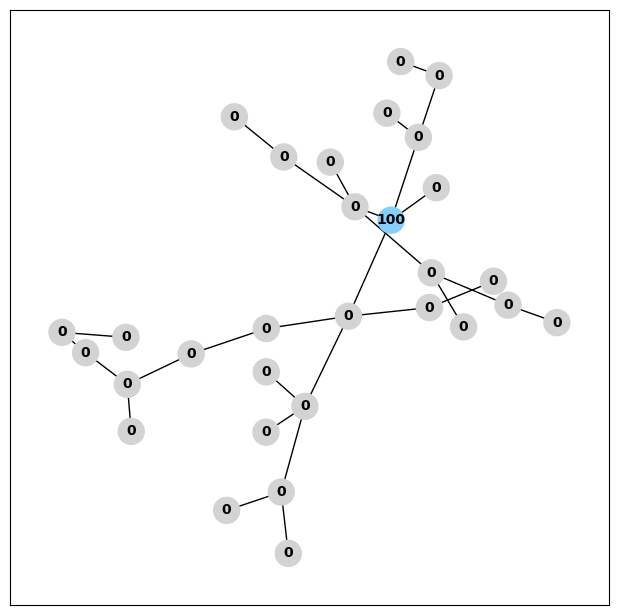

In [27]:
render(G, node_color)

In [ ]:
os.mkdir('a')
os.mkdir('a')
# shutil.rmtree('a')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FileExistsError: ignored

### add render() function to environment

In [161]:
### main.py
import os
import shutil

class NodeInvasionEnv(gym.Env):
    def __init__(self, max_timestep=200, render_mode='np_array', graph=None, mainNode='S', n_nodes=30, n_edges=5, delta_energy=1):
        self.render_mode = render_mode   # 'np_array' -> obs; 'human' -> video
        self.max_timestep = max_timestep if self.render_mode == 'np_array' else 120    # 'human' render mode takes 30x longer time to run an episode
        self.delta_energy = delta_energy
        self.timestep = 0

        self.graph = graph
        self.mainNode = mainNode
        if not self.graph:
            self.graph = WarGraph(mainNode, n_edges=7)
            nodes = self.graph.generate_graph(n_nodes=n_nodes, n_edges=n_edges)
            # self.graphNodes = self.graph.nodes

        self.graph.reset_nodes()
        self.graph.initialize_mainNode(mainNode)   # mainNode can be changed later
        self.graphNodes = self.graph.nodes

        if self.render_mode == 'human':
          self.G, self.node_color, self.node_color_dict = self._initialize_nx_graph(self.graphNodes)
          self.root_path = "nodeGraph"
          self.img_paths = []
          self.image_idx = 0

          if os.path.exists(self.root_path):
            shutil.rmtree(self.root_path)
          os.mkdir(self.root_path)
          os.mkdir(self.root_path + '/images')

        self.graphNodeIdx = {idx: i for idx, i in enumerate(list(self.graphNodes.keys()))}   # index for each nodes
        self.inv_graphNodeIdx = {v:k for k, v in self.graphNodeIdx.items()}

        self.obs = np.array([(node.energy, int(node.occupied)) for node in self.graphNodes.values()])
        self.n_nodes = self.obs.shape[0]

        self.observation_space = MultiDiscrete([101, 2])
        self.action_space = MultiDiscrete([self.n_nodes] * 2)

    def reset(self):
        self.timestep = 0
        self.graph.reset_nodes()
        self.graph.initialize_mainNode(self.mainNode)
        if self.render_mode == 'human':
          if os.path.exists(self.root_path):
            shutil.rmtree(self.root_path)
          os.mkdir(self.root_path)
          os.mkdir(self.root_path + '/images')
        return np.array([(node.energy, int(node.occupied)) for node in self.graphNodes.values()])

    # initialize nx graph
    @staticmethod
    def _initialize_nx_graph(nodes: dict[str, WarGraphNode]):
      G = nx.Graph()
      node_color_dict = dict()
      for node in nodes.values():
        color = 'lightgray' if node.energy == 0 else 'lightskyblue'
        node_color_dict[node.name] = color
        G.add_node(node.name, energy=node.energy, full=node.full, occupied=node.occupied)
      node_color = list(node_color_dict.values())

      for node in nodes.values():
        u = node.name
        for v in node.edges:
          G.add_edge(u, v)
      return G, node_color, node_color_dict

    # a function to get index of key in dict
    @staticmethod
    def keyindex(d: dict, key):
      i = 0
      for k, v in d.items():
        if k == key:
          return i
        i += 1
      return -1

    # update energy per step
    def __update_energy(self):
        for gNode in self.graphNodes.values():
            if gNode.occupied and 100 - gNode.energy >= self.delta_energy:
                gNode.energy += self.delta_energy

    # update available nodes in graph(indicates which nodes in the graph can be selected to diffuse)
    # call this function before end of a step(after success diffusion and energy update)
    def __update_available_nodes(self):
        # first requirement: node is occupied
        occupied_nodes = [node for _, node in self.graphNodes.items() if node.occupied]
        # second requirement: node.energy > 50
        for node in occupied_nodes:
          # we remove those nodes in available nodes where energy <= 50
          node_in_available = node.name in self.graph.available_nodes.keys()
          if node.energy <= 50 and node_in_available:
            _ = self.graph.available_nodes.pop(node.name)
          if node.energy > 50 and not node_in_available:
            self.graph.available_nodes[node.name] = node

    def __save_nx_graph(self):
        """this function should be called when graph is modified -- success diffusion or energy updated"""
        labels = nx.get_node_attributes(self.G, 'energy')

        plt.figure(figsize=(17, 17))
        subax1 = plt.subplot(224)

        # set seed to fix position of all nodes
        optimal_distance = (1 / math.sqrt(self.G.number_of_nodes())) * 2   # double of default optimal distance
        nx.draw_networkx(self.G, node_color=self.node_color, pos=nx.spring_layout(self.G, seed=1, k=optimal_distance),
                        labels=labels, font_size=10, font_weight='bold', node_size=350)

        img_fullpath = self.root_path + '/images' + f'/{self.image_idx}.png'
        self.img_paths.append(img_fullpath)
        plt.savefig(img_fullpath, bbox_inches='tight')
        plt.close()

        self.image_idx += 1

    # update nx graph upon success diffusion operation
    def __nx_graph_diffusion(self, selected_nodeName, target_nodeName):
        # change color of diffused node upon effective diffusion
        self.G.nodes()[selected_nodeName]['energy'] -= 50
        self.G.nodes()[target_nodeName]['energy'] = 50
        self.G.nodes()[target_nodeName]['occupied'] = True
        self.node_color[self.keyindex(self.node_color_dict, target_nodeName)] = 'lightskyblue'

    def step(self, action):
        # 1. diffuse energy
        selected_nodeName, target_nodeName = self.graphNodeIdx[action[0]], self.graphNodeIdx[action[1]]
        try:
            # reward for success diffusion: total_energy / n_nodes
            self.graph.diffusion(selected_nodeName, target_nodeName)
            reward = int(sum(self.obs[:, 0]) / self.n_nodes)

            if self.render_mode == 'human':
              # 1.1 update nx graph nodes for diffuse operation
              self.__nx_graph_diffusion(selected_nodeName, target_nodeName)

              # 1.2 take a snapshot of success diffusion
              self.__save_nx_graph()

        except AssertionError as ae:
            # penalty for invalid difussion: -1
            reward = -1


        # 3. update energy(should be done after snapshot of success diffusion)
        # 3.1 update energy for graph
        self.__update_energy()

        # 3.2 update energy attribute for nx graph
        if self.render_mode == 'human':
          for name, node in self.G.nodes(data=True):
            # condition: node is occupied and 100 - node energy >= delta energy(delta energy will change someday)
            if node['occupied'] and 100 - node['energy'] >= self.delta_energy:
              node['energy'] += self.delta_energy

          # 3.3 take snapshot after energy updated
          self.__save_nx_graph()


        # 4. update available nodes in graph(indicates which nodes in the graph can be selected to diffuse)
        self.__update_available_nodes()


        # 5. update step outputs(obs, reward, done, _)
        # 5.1 observation, timestep
        # obs: [energy, int(occupied)] for each nodes
        self.obs = np.array([(node.energy, int(node.occupied)) for node in self.graphNodes.values()])
        self.timestep += 1

        # 5.2 done
        truncation = self.timestep >= self.max_timestep
        termination = (sum(self.obs[:, 0]) / self.n_nodes) == 100   # terminated when all nodes have full energy

        done = truncation or termination

        # 5.3 reward
        # update reward if done
        if done:
            reward = int(sum(self.obs[:, 0]) / self.n_nodes)

        return self.obs, reward, done, dict()

    @staticmethod
    def _visualize_rewards(rewards):
        plt.plot(rewards)
        plt.xlabel("Timestep")
        plt.ylabel("Reward")
        plt.show()

    def render(self, interval=400):
        interval = max(interval, 400)
        if self.render_mode == 'np_array':
          return plt.imread(self.img_paths[-1])

        elif self.render_mode == 'human':
          images = [plt.imread(img_path) for img_path in self.img_paths]
          # visualize graph as video
          fig, ax = plt.subplots()
          rng = np.random.default_rng(19680801)
          plt.axis('off')
          artists = []
          colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple']
          for img in images:
              container = ax.imshow(img)
              artists.append([container])

          ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=interval)
          plt.close()
          return HTML(ani.to_html5_video())

In [162]:
env = NodeInvasionEnv(max_timestep=200, n_nodes=30, n_edges=3, render_mode='human')
# env.graph.nodes

In [111]:
env.max_timestep = 10000

In [52]:
from tqdm import tqdm

bar = tqdm(total=env.max_timestep)

  0%|          | 0/200 [00:00<?, ?it/s]

In [163]:
obs = env.reset()

# nodes_record = [graph.nodes]
rewards = []
bar = tqdm(total=env.max_timestep)

done = False
while not done:
  graph = env.graph
  selected_nodeName = random.choice(list(graph.available_nodes.keys()))
  selectedNode = graph.nodes[selected_nodeName]
  target_nodeName = random.choice(selectedNode.edges)
  targetNode = graph.nodes[target_nodeName]

  action = (env.inv_graphNodeIdx[selected_nodeName], env.inv_graphNodeIdx[target_nodeName])
  next_obs, reward, done, _ = env.step(action)

  obs = next_obs
  rewards.append(reward)
  # nodes_record.append(graph.nodes)

  bar.update(1)
bar.close()

# env.timestep

100%|██████████| 120/120 [00:36<00:00,  3.26it/s]


In [164]:
env.render()

In [ ]:
env.img_paths

In [148]:
from matplotlib import animation
import os
from IPython.display import HTML

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [145]:
images = [plt.imread(path) for path in env.img_paths]

In [150]:
# visualize graph as video
fig, ax = plt.subplots()
rng = np.random.default_rng(19680801)
plt.axis('off')
artists = []
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple']
for img in images:
    container = ax.imshow(img)
    artists.append([container])

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
plt.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [151]:
HTML(ani.to_html5_video())